# Libraries

In [1]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import MaxPooling2D, concatenate, Convolution2D, Activation
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical, get_file
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import math
import logging
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Data loading and exploration

In [2]:
batch_size = 32

In [3]:
'''Determinar la ruta en la que se encuentra la division de las carpetas con las imagenes o datos.'''
fpath = 'C:/Users/lesly/Mineria/Unidad3/Proy_Mineria/Lab1/eliminar_ruido'
'''Variable en la que se realiza un random de 9 imagenes.'''
random_seed = 9
'''Obtiene la lista de todos los archivos y directorios en el directorio especificado.'''
categories = os.listdir(fpath)
'''Impresion del contenido de la variable categories.'''
print("Lista de categorías = ",categories,"\n\nNumero de categorias = ", len(categories))

Lista de categorías =  ['con_mascara', 'sin_mascara'] 

Numero de categorias =  2


In [4]:
'''Funcion encargada de cargar imágenes y etiquetas'''
def load_images_and_labels(categories):
    #creacion de una variable de tipo array que va a contener las imagenes
    img_lst=[]
    #creacion de una variable ded tipo array que va a contener las etiquetas
    labels=[]
    #tamaño estandar para todas las imagenes
    TAMANO_IMG = 100
    #ciclo encargado de recorrer todas las carpetas
    for index, category in enumerate(categories):
        #ciclo encargado de recorrer el contenido de una carpeta
        for image_name in os.listdir(fpath+"/"+category):
            #devuelve una matriz 2D o 3D basada en el número de canales de color presentes en la imagen
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            #estandarizacion de un solo tamaño para todas las imagenes
            img = cv2.resize(img, (TAMANO_IMG, TAMANO_IMG))
            #definicion del color que contine las imagenes
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #representar distintos colores a partir de la mezcla de estos tres colores primarios
            img_array = Image.fromarray(img, 'RGB')
            # permite agregar nuevos elementos a una lista en este caso las imagenes
            img_lst.append(np.array(img_array))
            # permite agregar nuevos elementos a una lista en este caso las etiquetas
            labels.append(index)
    #retorno de la lista de imagenes y etiquetas
    return img_lst, labels
'''Uso de la funcion que permite la carga de las imagenes y etiquetas'''
images, labels = load_images_and_labels(categories)
'''Impresion del numero las imagenes y etiquetas que se han cargado'''
print("Numero de imagenes cargadas = ",len(images),"\nNumero de etiquetas cargadas= ",len(labels))
print(type(images),type(labels))


Numero de imagenes cargadas =  6716 
Numero de etiquetas cargadas=  6716
<class 'list'> <class 'list'>


In [5]:
'''crear un array a partir de un iterador como una simple lista de imagenes'''
images = np.array(images)
'''crear un array a partir de un iterador como una simple lista de etiquetas'''
labels = np.array(labels)
'''Impresion de las etiquetas e imagenes'''
print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
'''Impresion de los tipos de datos que se han ejecutado'''
print(type(images),type(labels))

Images shape =  (6716, 100, 100, 3) 
Labels shape =  (6716,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


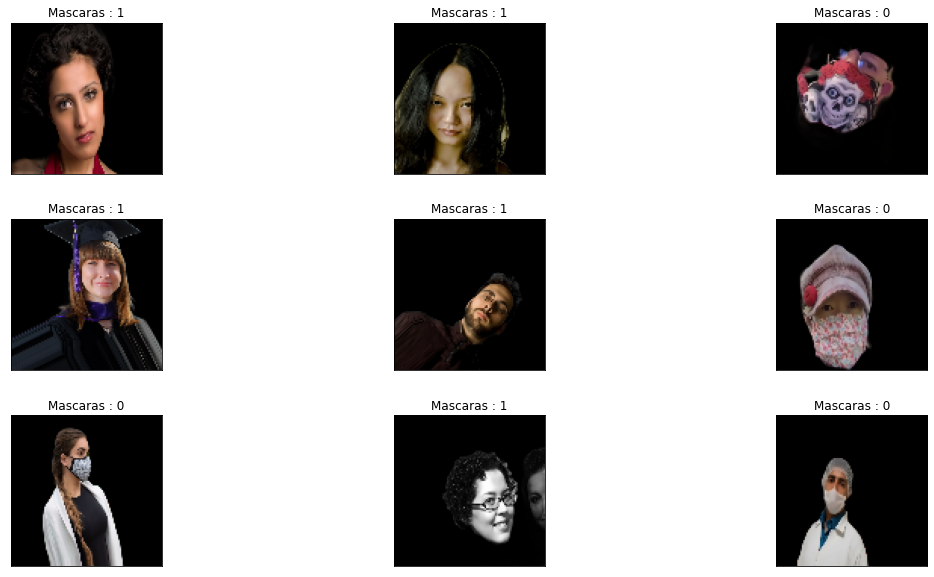

In [6]:
'''Funcion que permite visualizar nueve imagenes aleatorias'''
def display_rand_images(images, labels):
    #tamaño de las figuras que se van a mostrar
    plt.figure(1 , figsize = (19 , 10))
    #variable contador de imagenes
    n = 0 
    #ciclo que se encarga de elegir nueve imagenes aleatorias
    for i in range(9):
        #contador de imagenes
        n += 1 
        #uso de la funcion random para no tomar imagenes secuenciales
        r = np.random.randint(0 , images.shape[0] , 1)
        #crea una figura con ejes
        plt.subplot(3 , 3 , n)
        #ajustar el diseño de la subtrama
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        #mostrar una imagen en una ventana
        plt.imshow(images[r[0]])
        #titulo de las imagenes que se van a visualizar
        plt.title('Mascaras : {}'.format(labels[r[0]]))
        # establecer las ubicaciones y etiquetas en el eje x
        plt.xticks([])
        # establecer las ubicaciones y etiquetas en el eje y
        plt.yticks([])
    #ejecucion de la grafica   
    plt.show()
'''Llamado de la funcion que permite visualizar nueve imagenes aleatorias.'''  
display_rand_images(images, labels)

# Prepare data for training the CNN model

In [7]:
'''Primer paso en el barajado de datos'''

'''obtener números igualmente espaciados en un rango dado'''
n = np.arange(images.shape[0])
'''Impresion de los valores que contiene la variable n'''
print("'n' valores antes de barajar = ",n)

'''Barajar todos los valores igualmente espaciados en la lista 'n' '''
np.random.seed(random_seed)
'''Se utiliza para mezclar una secuencia (lista)'''
np.random.shuffle(n)
'''Imprimir valores barajados'''
print("\n'n' valores despues de barajar = ",n)

'n' valores antes de barajar =  [   0    1    2 ... 6713 6714 6715]

'n' valores despues de barajar =  [4947 3648 5547 ...  501 4444  382]


In [8]:
'''Segundo paso en el barajado de los datos'''

'''mezclar imágenes y datos de etiquetas correspondientes en ambas listas'''
images = images[n]
labels = labels[n]
print("Forma de las imágenes después de barajar = ",images.shape,"\nForma de las etiquetas después de barajar = ",labels.shape)

Forma de las imágenes después de barajar =  (6716, 100, 100, 3) 
Forma de las etiquetas después de barajar =  (6716,)


In [9]:
'''realiza una copia de un array aplicandole otro tipo de datos utilizando el método asociado a un array en las imagenes'''
images = images.astype(np.float32)
'''realiza una copia de un array aplicandole otro tipo de datos utilizando el método asociado a un array en las etiquetas'''
labels = labels.astype(np.int32)
images = images/255
'''Impresion de las imagenes'''
print("Forma de las imágenes después de la normalización = ",images.shape)

Forma de las imágenes después de la normalización =  (6716, 100, 100, 3)


In [10]:
'''Division del conjunto de datos para que se puedan ejecutar en distintos porcentajes de entrenamiento y pruebas'''
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

'''longitud de entrenamiento de imagenes '''
print("x_train shape = ",x_train.shape)
'''longitud de entrenamiento de etiquetas '''
print("y_train shape = ",y_train.shape)
'''longitud de pruebas de imagenes '''
print("\nx_test shape = ",x_test.shape)
'''longitud de pruebas de etiquetas '''
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (5314, 100, 100, 3)
y_train shape =  (5314,)

x_test shape =  (1344, 100, 100, 3)
y_test shape =  (1344,)

x_val shape =  (58, 100, 100, 3)
y_val shape =  (58,)


In [11]:
##One-hot-encode
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)

# Define CNN model

In [12]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [13]:
pre_trained_model = SqueezeNet(input_shape=x_train[0].shape, include_top=False, weights="imagenet")

In [14]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
conv1
relu_conv1
pool1
fire2/squeeze1x1
fire2/relu_squeeze1x1
fire2/expand1x1
fire2/expand3x3
fire2/relu_expand1x1
fire2/relu_expand3x3
fire2/concat
fire3/squeeze1x1
fire3/relu_squeeze1x1
fire3/expand1x1
fire3/expand3x3
fire3/relu_expand1x1
fire3/relu_expand3x3
fire3/concat
pool3
fire4/squeeze1x1
fire4/relu_squeeze1x1
fire4/expand1x1
fire4/expand3x3
fire4/relu_expand1x1
fire4/relu_expand3x3
fire4/concat
fire5/squeeze1x1
fire5/relu_squeeze1x1
fire5/expand1x1
fire5/expand3x3
fire5/relu_expand1x1
fire5/relu_expand3x3
fire5/concat
pool5
fire6/squeeze1x1
fire6/relu_squeeze1x1
fire6/expand1x1
fire6/expand3x3
fire6/relu_expand1x1
fire6/relu_expand3x3
fire6/concat
fire7/squeeze1x1
fire7/relu_squeeze1x1
fire7/expand1x1
fire7/expand3x3
fire7/relu_expand1x1
fire7/relu_expand3x3
fire7/concat
fire8/squeeze1x1
fire8/relu_squeeze1x1
fire8/expand1x1
fire8/expand3x3
fire8/relu_expand1x1
fire8/relu_expand3x3
fire8/concat
fire9/squeeze1x1
fire9/relu_squeeze1x1
fire9/expand1x1
fire9/expand3x3
fire

In [15]:
last_layer = pre_trained_model.get_layer('fire9/concat')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='sigmoid')(x)
model = tf.keras.Model(pre_trained_model.input, x)

# Train model

In [16]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 49, 49, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 49, 49, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 24, 24, 64)   0           relu_conv1[0][0]                 
______________________________________________________________________________________________

In [18]:
steps_per_epoch = (x_train.shape[0]//batch_size)
validation_steps = (x_val.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [19]:
x_train.shape,y_train.shape

((5314, 100, 100, 3), (5314, 3))

In [20]:
start_time = time.time()

history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 50,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

logging.basicConfig(filename="CNN-basedTL_SqueezeNet_log.txt", level=logging.INFO)
logging.info("Training Execution Time:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/50
166/166 [==============================] - 11s 57ms/step - loss: 1.1382 - acc: 0.6291 - val_loss: 0.7765 - val_acc: 0.5000
Epoch 2/50
166/166 [==============================] - 9s 54ms/step - loss: 0.5668 - acc: 0.7103 - val_loss: 0.5790 - val_acc: 0.6562
Epoch 3/50
166/166 [==============================] - 9s 54ms/step - loss: 0.5246 - acc: 0.7344 - val_loss: 0.5956 - val_acc: 0.5938
Epoch 4/50
166/166 [==============================] - 9s 54ms/step - loss: 0.5214 - acc: 0.7374 - val_loss: 0.5235 - val_acc: 0.7188
Epoch 5/50
166/166 [==============================] - 9s 54ms/step - loss: 0.5206 - acc: 0.7355 - val_loss: 0.5019 - val_acc: 0.7500
Epoch 6/50
166/166 [==============================] - 9s 55ms/step - loss: 0.5235 - acc: 0.7363 - val_loss: 0.4756 - val_acc: 0.7500
Epoch 7/50
166/166 [==============================] - 10s 58ms/step - loss: 0.4963 - acc: 0.7592 - val_loss: 0.5014 - val_acc: 0.7500
Epoch 8/50
166/166 [==============================] - 9s 55ms/step 

In [21]:
model_json = model.to_json()
with open("SqueezeNet_mascaras_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("SqueezeNet_mascaras_Classifier.h5")
print("Saved model to disk")
model.save_weights("SqueezeNet_mascaras.h5")

Saved model to disk


# Evaluation model

In [22]:
start_time = time.time()

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Evaluation Execution Time: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

42/42 [==============================] - 3s 52ms/step - loss: 0.4067 - acc: 0.8237
test_loss: 40.67
test_accuracy: 82.37


In [23]:
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
y_pred = model_probs
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_reduced, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 82.37
F1 score: 82.19
Precision: 83.89
Recall: 82.37


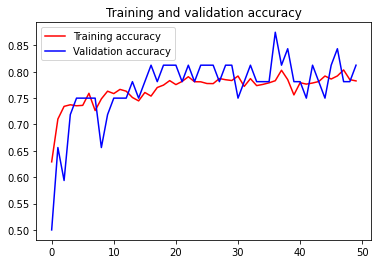

In [24]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-based TL.png")
plt.show() 

In [25]:
y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 


In [26]:
y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(y_pred,axis = 1) 

In [27]:
confusion = confusion_matrix(Y_true,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[618  48]
 [189 489]]


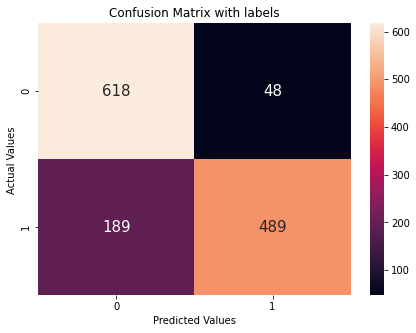

In [28]:

plt.figure(figsize=(7, 5))
plt.xlabel("Preciccion")
plt.ylabel("Actual")
gf = sns.heatmap(confusion, annot=True,  annot_kws={'size': 15}, fmt = "d")
gf.set_title('Confusion Matrix with labels')
gf.set_xlabel('Predicted Values')
gf.set_ylabel('Actual Values ')
plt.show()